In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

# Download the data
stock = "CVX"
data = yf.download(stock, start="2019-01-01", end=datetime.now().strftime('%Y-%m-%d'))

# Calculate new features
data['Daily Change'] = data['Close'].pct_change()  # Daily Percentage Change
data['Smoothed Daily Change'] = data['Daily Change'].rolling(window=15).mean()
data['5-Day MA'] = data['Close'].rolling(window=5).mean()  # 5-Day Moving Average
data['10-Day MA'] = data['Close'].rolling(window=10).mean()  # 10-Day Moving Average
data['RSI'] = data['Close'].diff().apply(lambda x: np.where(x > 0, x, 0)).rolling(window=14).mean() / \
              data['Close'].diff().abs().rolling(window=14).mean() * 100  # RSI

# Filling NaN values with Back Fill
data['Daily Change'].fillna(method='bfill', inplace=True)
data['Smoothed Daily Change'].fillna(method='bfill', inplace=True)
data['5-Day MA'].fillna(method='bfill', inplace=True)
data['10-Day MA'].fillna(method='bfill', inplace=True)
data['RSI'].fillna(method='bfill', inplace=True)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Smoothed Daily Change', '5-Day MA', '10-Day MA', 'Close', 'Volume', 'RSI']])

threshold = int(np.ceil(len(scaled_data) * 0.9))
features = 6

# Function to create a supervised learning problem
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i+time_step), :]
        X.append(a)
        Y.append(data[i + time_step, 3])  # 3 denotes the 'Close' column in scaled_data
    return np.array(X), np.array(Y)

# Create dataset for training
time_step = 30  # Number of days look-back for prediction
X_train, y_train = create_dataset(scaled_data[:threshold], time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], time_step, features)



[*********************100%%**********************]  1 of 1 completed


In [2]:
from tensorflow.keras.callbacks import EarlyStopping
#  Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
30/30 [==============================] - 11s 95ms/step - loss: 0.2779 - val_loss: 0.0278
Epoch 2/100
30/30 [==============================] - 1s 31ms/step - loss: 0.0302 - val_loss: 0.0277
Epoch 3/100
30/30 [==============================] - 1s 31ms/step - loss: 0.0209 - val_loss: 0.0293
Epoch 4/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0181 - val_loss: 0.0293
Epoch 5/100
30/30 [==============================] - 2s 50ms/step - loss: 0.0163 - val_loss: 0.0261
Epoch 6/100
30/30 [==============================] - 1s 44ms/step - loss: 0.0139 - val_loss: 0.0264
Epoch 7/100
30/30 [==============================] - 1s 30ms/step - loss: 0.0142 - val_loss: 0.0374
Epoch 8/100
30/30 [==============================] - 1s 32ms/step - loss: 0.0124 - val_loss: 0.0512
Epoch 9/100
30/30 [==============================] - 1s 41ms/step - loss: 0.0121 - val_loss: 0.0270
Epoch 10/100
30/30 [==============================] - 1s 30ms/step - loss: 0.0114 - val_loss: 0.027

In [8]:
import numpy as np

# Create test set
test_data = scaled_data[threshold:]

x_test, y_test = create_dataset(test_data, time_step)

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])

# Get the model's predicted values
predictions = model.predict(x_test)
predictions = predictions.flatten()  # Flatten the predictions array to match y_test's shape


4/4 [==============================] - 0s 10ms/step


In [13]:
import numpy as np


# Number of future time steps to forecast
num_forecast_steps = 30

# Initialize a list to store future forecasts
future_forecasts = []

# Start with the last window of available data, ensure it has the correct shape
current_input = scaled_data[threshold - time_step:threshold,:].reshape(1, time_step, features)

for _ in range(num_forecast_steps):
    # Predict the next time step
    next_forecast = model.predict(current_input)
    # Append the forecasted 'Close' price
    future_forecasts.append(next_forecast[0, 0])

    # Update the input for the next prediction
    # Shift the data left, and place the new forecast at the end of the sequence
    new_row = current_input[0, -1, :].copy()  # Copy the last row to modify it
    new_row[3] = next_forecast[0, 0]  # Assuming 'Close' is at index 3
    current_input = np.roll(current_input, -1, axis=1)  # Shift everything left
    current_input[0, -1, :] = new_row  # Insert the new row at the end

# Print or process the future forecasts as needed
print("Future forecasts:", future_forecasts)


1/1 [==============================] - 0s 22ms/step
Future forecasts: [1.1972743, 1.2118013, 1.2199796, 1.2287207, 1.2247195, 1.1966639, 1.1958097, 1.1949173, 1.1955413, 1.1932206, 1.1948289, 1.1978624, 1.2002965, 1.1943042, 1.1935754, 1.1914393, 1.1913317, 1.1924802, 1.1856424, 1.1824105, 1.1745576, 1.1715392, 1.172158, 1.1594489, 1.1589072, 1.1577137, 1.1625684, 1.1633043, 1.1656955, 1.1687441]


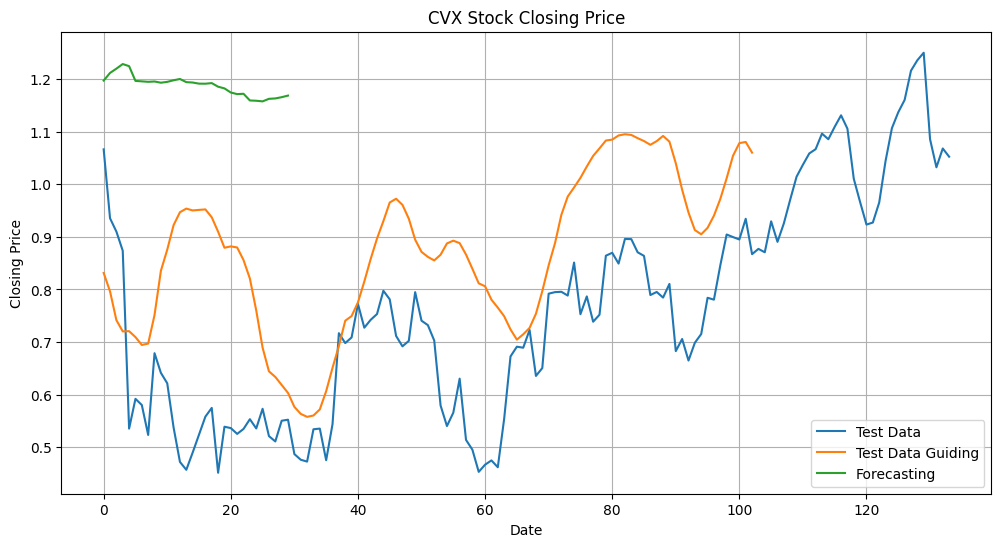

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

closing_data = scaled_data.T[3]

plt.plot(closing_data[threshold:], label='Test Data')
# Plot train_data + x_test
plt.plot(predictions, label='Test Data Guiding')

plt.plot(future_forecasts, label='Forecasting')

plt.title(f'{stock} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid()
plt.legend()
plt.show()

In [15]:
mse = np.mean((predictions- y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.01811481272797714


In [16]:
mse = np.mean((future_forecasts- y_test[:30]) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.3185502882260586
